<a href="https://colab.research.google.com/github/B104020057/PIS2022/blob/main/FinalReport05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 專案報告: LINE Bot Gemini 聊天機器人

## 專案背景與動機

隨著生成式 AI 技術的快速發展，愈來愈多應用將語言模型整合進日常工具中，使人們能透過自然語言與系統互動。然而，多數生成式 AI 的使用介面仍侷限於網頁平台，對一般使用者來說操作門檻較高。

本專案目的是將 Google Gemini 模型整合至 LINE Bot 平台，讓使用者能透過 LINE 這個熟悉的社交介面，直接與 Gemini 對話互動，解決日常問題、輔助學習，或作為生活助理工具。

## 專案目標

- 建立一個可與 Google Gemini 模型連接的 LINE Bot。
- 支援上下文記憶功能，使對話更自然連貫。
- 開發學習助理模式，自動生成筆記與小測驗。
- 整合排程與提醒功能，提升工具實用性。

## 系統設計與架構

### 系統功能分析

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | LINE 使用者傳送訊息，透過 Webhook 接收並觸發事件處理器。 |
| Gemini API 連接 | 呼叫 Google Gemini 2.0 模型進行文字生成，支援高速應答與自然語言處理。 |
| 回應傳送機制 | 將 AI 回應以文字訊息回傳給使用者，根據使用者輸入指令做對應分類。 |
| 上下文記憶功能 | 為每位使用者建立對話歷史，保留前幾輪對話內容，以便連續性回應與邏輯推論。 |
| 學習助理模式 | Bot 可根據使用者輸入的主題整理筆記內容，並支援小測驗產出（選擇題形式），協助用戶自主學習。 |
| 排程與提醒整合 | 使用者可輸入提醒指令（如 `/提醒 明天交作業`），Bot 將自動儲存並回應，後續可整合至通知平台。 |
| 指令處理功能 | 支援使用 `/筆記 主題`、`/測驗 主題`、`/提醒 事項` 指令，並依指令自動分類處理。 |
| 錯誤處理機制 | 當 Gemini 回應失敗或使用者未輸入主題時，自動回應提示訊息。 |



### 系統架構圖

```
User
  ↓
LINE 前端平台
  ↓
Webhook（Flask伺服器）
  ↓
Gemini API（含記憶與指令解析）
  ↓
功能模組（筆記 / 測驗 / 提醒 / 回應）
  ↓
LINE 使用者收到回應
```

### 使用的技術

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| Web 框架 | Flask |
| 對話平台 | LINE Messaging API |
| AI 模型 API | Google Gemini 2.0 Flash |
| 記憶模組 | Dict-based Session 記憶管理（依 user_id）|
| 任務模組 | 指令解析與分派邏輯（/筆記、/測驗、/提醒）|
| 部署環境 | Google Colab + Ngrok（開發階段）|

## 測試方式

| 測試功能 | 測試指令（LINE 輸入內容） | 預期回應 |
|-------------|--------------------------|------------|
| 上下文記憶 | 我想去日本旅遊 → 那邊的花費？ | Bot 會延續主題正確回應花費內容 |
| 學習筆記 | /筆記 經濟學 | 條列式列出經濟學5項核心概念 |
| 小測驗產出 | /測驗 心理學 | 3 題選擇題，附選項與正解 |
| 記錄提醒 | /提醒 明天上午9點上課 | 回應：✅ 已為你記下提醒：... |


# 專案成果與效益

## 系統程式

In [4]:
!pip install line-bot-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 16.2 MB/s eta 0:00:00


In [6]:
!pip install flask flask-ngrok line-bot-sdk google-generativeai

In [10]:
!pip install pyngrok flask-ngrok

In [16]:
# for colab 啟動 ngrok
from google.colab import userdata
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok

def ngrok_start():
    ngrok.set_auth_token(userdata.get('NGROK_AUTHTOKEN'))
    ngrok.connect(5000)
    run_with_ngrok(app)

from flask import Flask, request, abort
from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.webhooks import MessageEvent, TextMessageContent
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest, TextMessage
)

app = Flask(__name__)
configuration = Configuration(access_token=userdata.get('CHANNEL_ACCESS_TOKEN'))
handler = WebhookHandler(userdata.get('CHANNEL_SECRET'))

@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'

# 對話記憶區（每個 user_id 對應一個 list）
session_dict = {}
MAX_TURNS = 5  # 最多記住幾句上下文
def ask_gemini_with_memory(user_id, new_message):
    history = session_dict.get(user_id, [])
    history.append({"role": "user", "parts": [new_message]})

    if len(history) > MAX_TURNS:
        history = history[-MAX_TURNS:]  # 只保留最新 MAX_TURNS 則

    session_dict[user_id] = history  # 更新記憶

    response = model.generate_content(history)
    history.append({"role": "model", "parts": [response.text]})
    session_dict[user_id] = history[-MAX_TURNS:]  # 更新並限制回應記憶

    return response.text

# Gemini 整合功能
import google.generativeai as genai

genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))
model = genai.GenerativeModel("gemini-2.0-flash-exp")

def ask_gemini(question):
    response = model.generate_content(question)
    return response.text

reminder_dict = {}  # 提醒暫存區：user_id ➜ [提醒文字]

@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    user_id = event.source.user_id
    text = event.message.text.strip()

    if text.startswith("/提醒"):
        reminder = text.replace("/提醒", "").strip()
        if reminder:
            reminder_dict.setdefault(user_id, []).append(reminder)
            reply_text = f"✅ 已為你記下提醒：{reminder}"
        else:
            reply_text = "⚠️ 請提供提醒內容，例如：/提醒 明天下午三點開會"

    elif text.startswith("/筆記"):
        topic = text.replace("/筆記", "").strip()
        if topic:
            prompt = f"請你扮演學習助理，幫我整理「{topic}」的重點，請條列式列出5點，適合筆記記錄使用。"
            reply_text = ask_gemini_with_memory(user_id, prompt)
        else:
            reply_text = "⚠️ 請指定主題，例如：/筆記 微積分"

    elif text.startswith("/測驗"):
        topic = text.replace("/測驗", "").strip()
        if topic:
            prompt = f"請出3題有關「{topic}」的選擇題，每題請附上4個選項並標示正確答案。"
            reply_text = ask_gemini_with_memory(user_id, prompt)
        else:
            reply_text = "⚠️ 請指定主題，例如：/測驗 行銷學"

    else:
        reply_text = ask_gemini_with_memory(user_id, text)

    # 回傳 LINE 訊息
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)
        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[TextMessage(text=reply_text)]
            )
        )

ngrok_start()

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://933e-34-16-193-232.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:49:06] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:49:07] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:49:12] "GET /callback HTTP/1.1" 405 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:49:18] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:49:29] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:49:33] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:50:14] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:50:30] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:50:58] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:51:20] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:51:31] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 03:51:44] "POST /callback HTTP/1.1" 200 -
INFO:werkzeu

## 系統畫面

### 1.上下文記憶

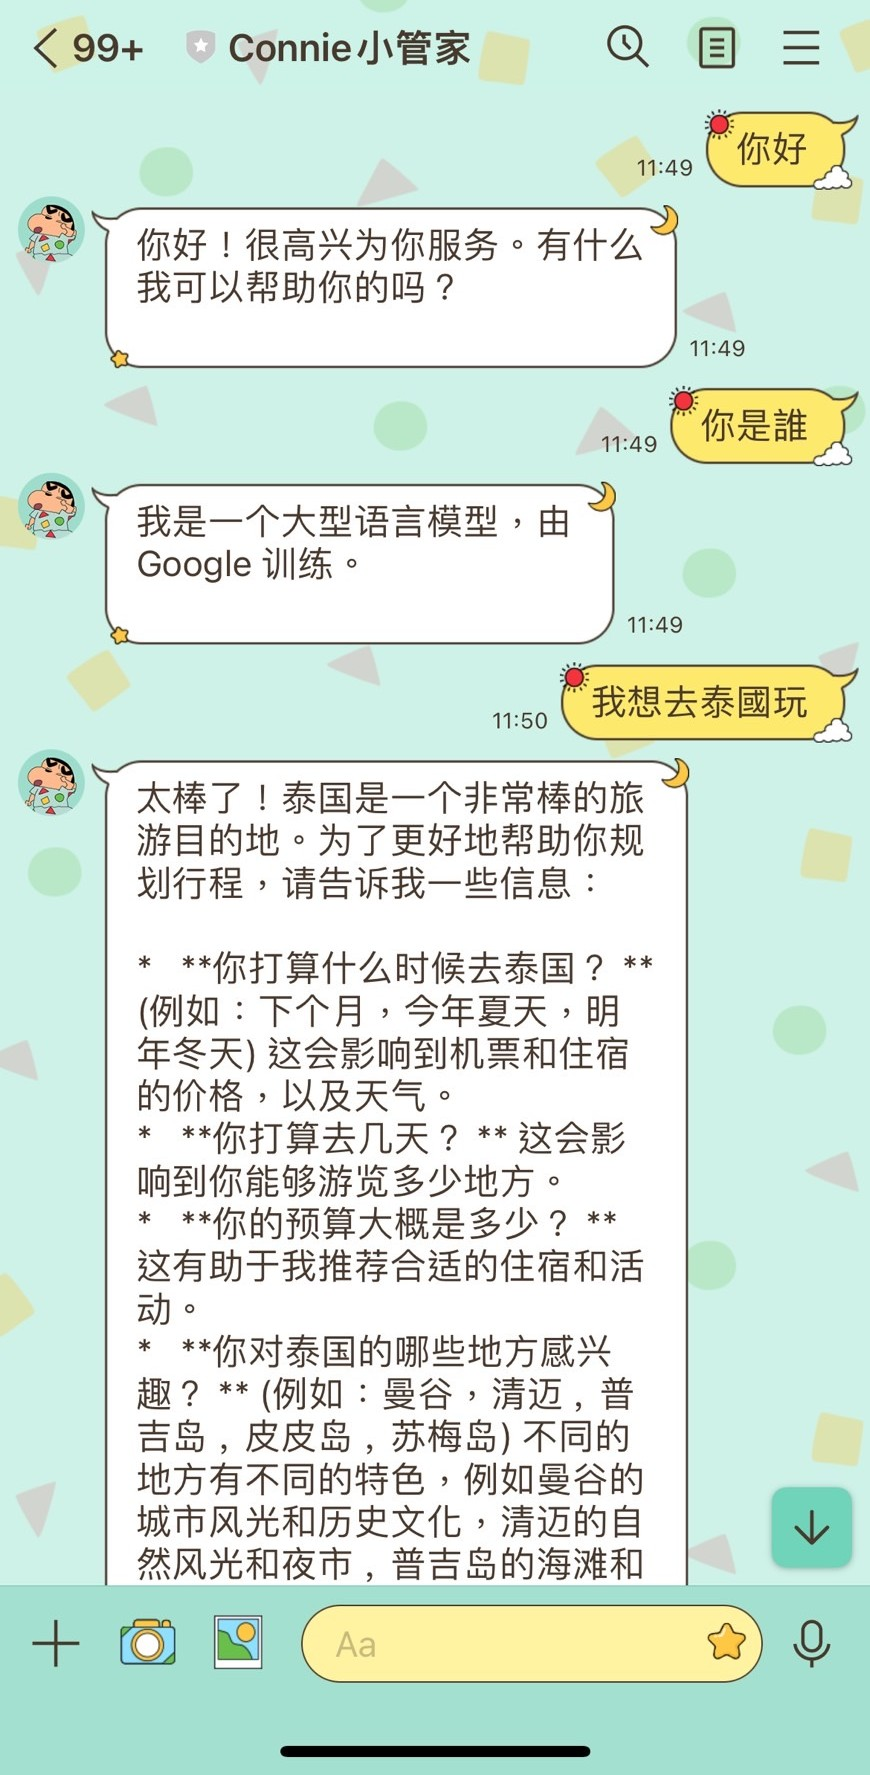

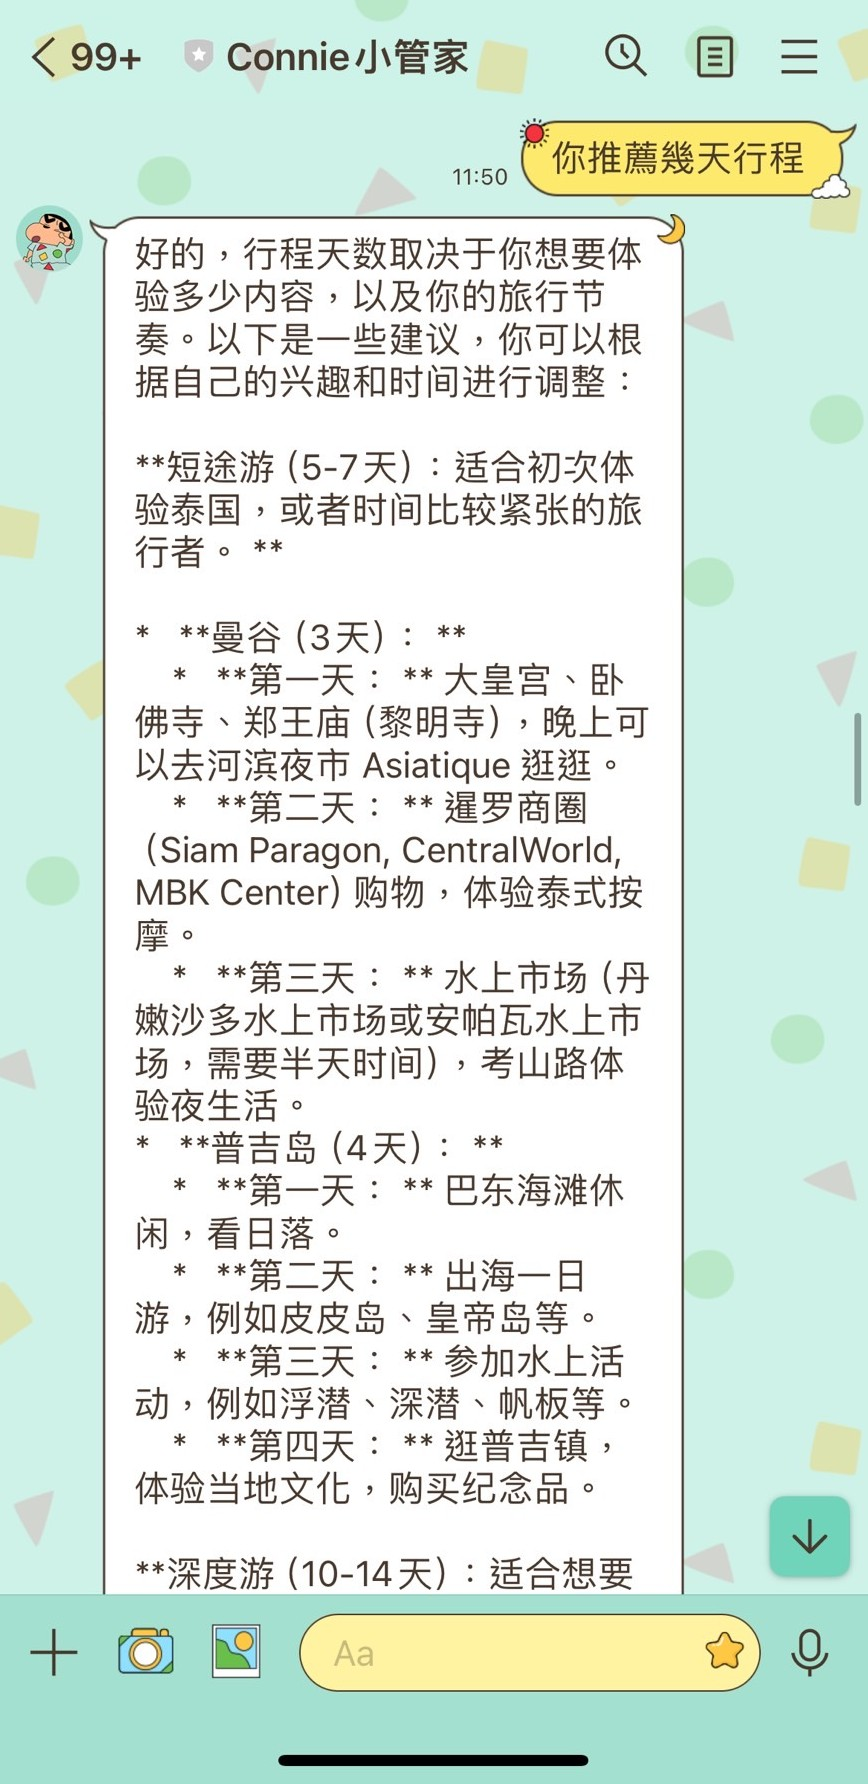

In [34]:
from IPython.display import Image, display

display(Image('/content/開頭+文本a.jpg', width=250))
display(Image('/content/延續文本.jpg', width=250))

### 2.學習筆記

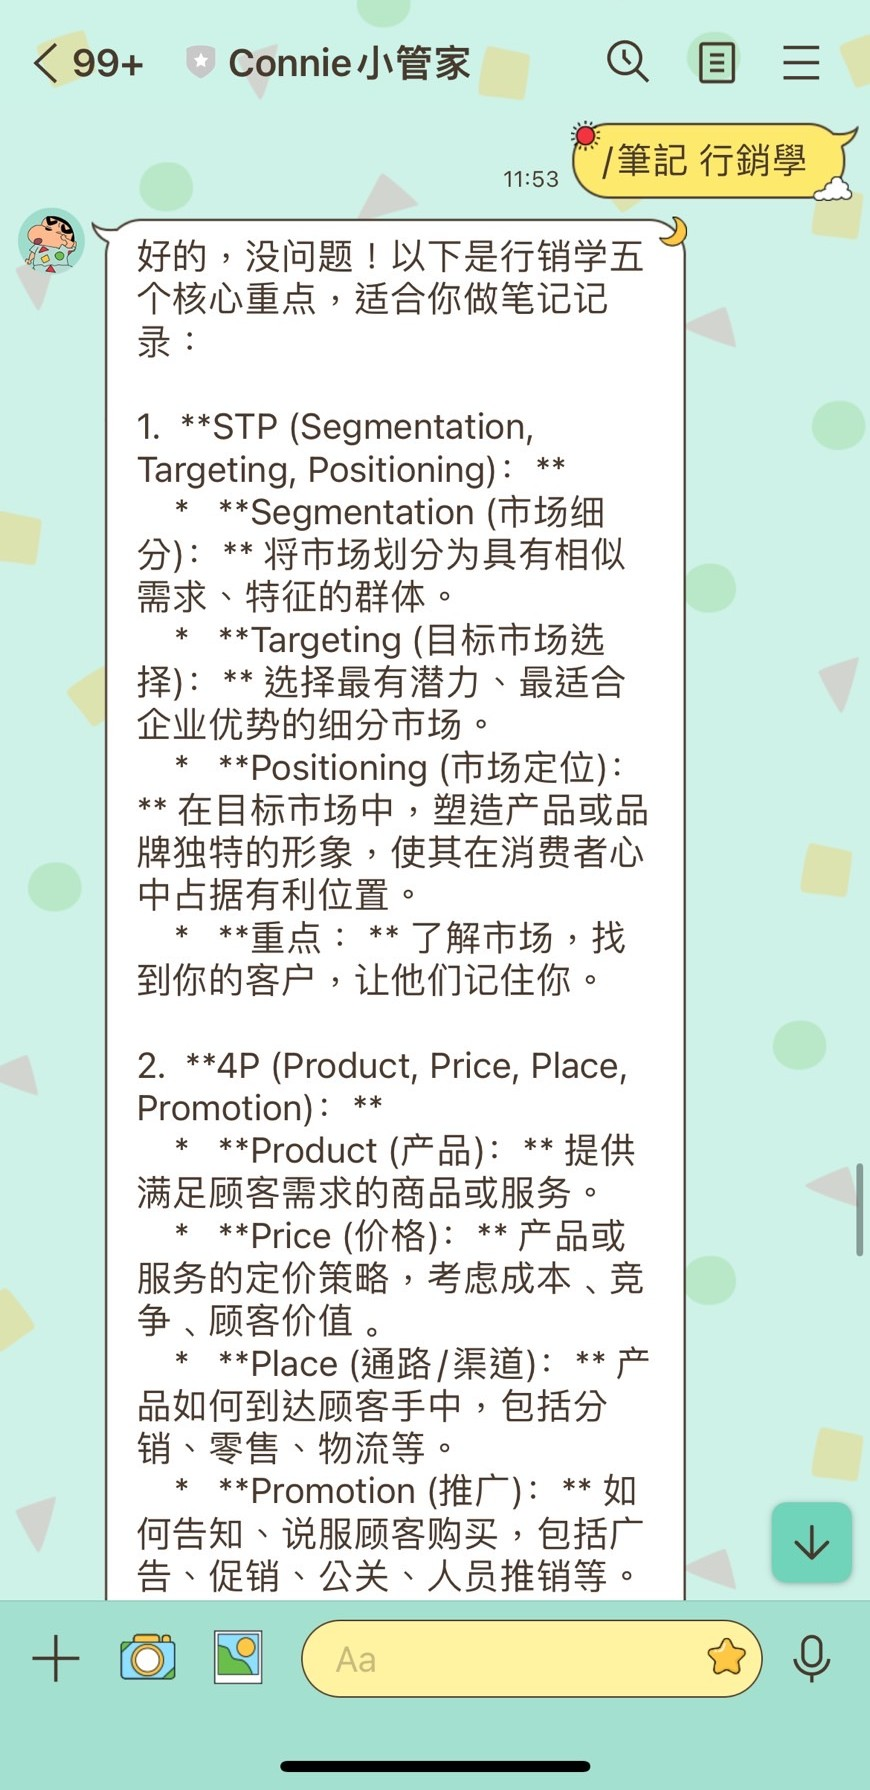

In [30]:
from IPython.display import Image
Image("/content/筆記.jpg", width=250)

### 3.小測驗產出

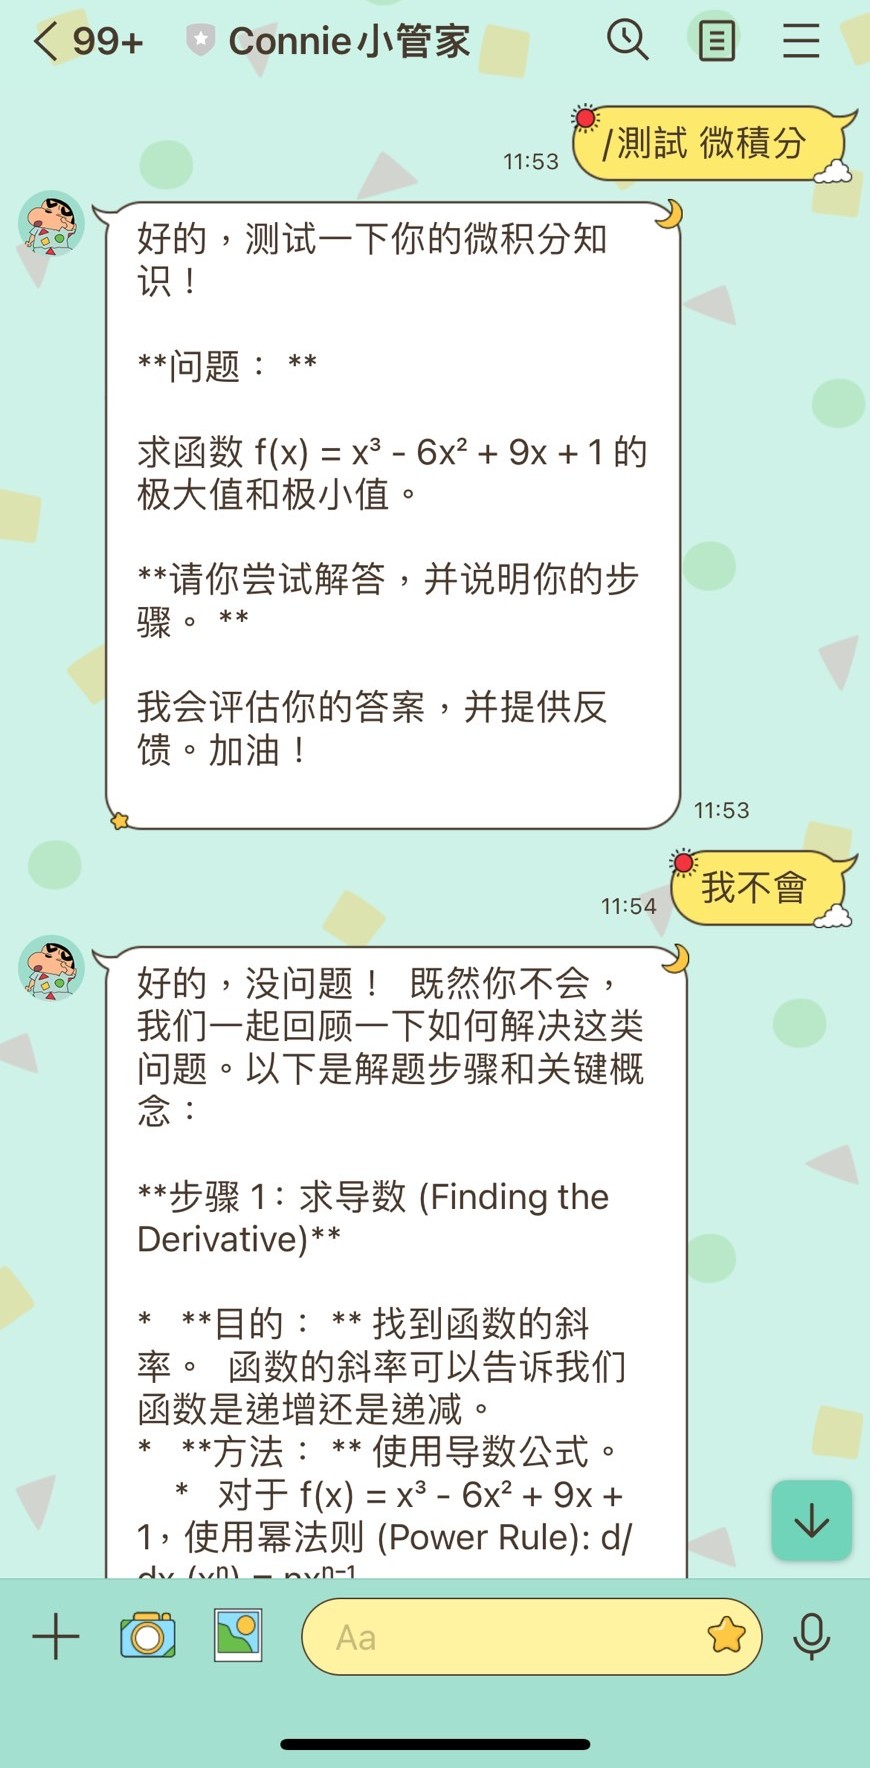

In [35]:
from IPython.display import Image
Image("/content/測試題+文本延續給答案.jpg", width=250)

### 4.記錄提醒

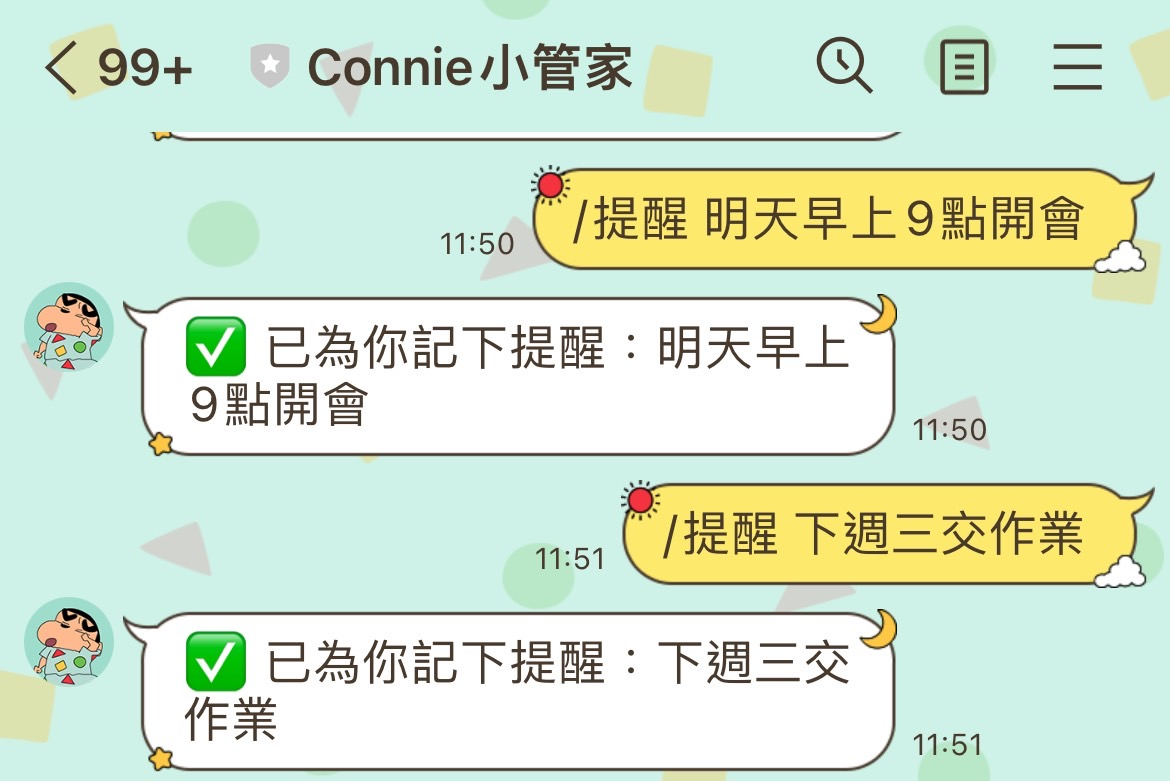

In [36]:
from IPython.display import Image
Image("/content/提醒.jpg", width=250)

## 成果展示


- 成功建立可與 Gemini 結合的 LINE 智慧助理。
- 可依指令分類執行筆記、測驗與提醒任務。
- 提供上下文記憶功能，使對話更自然不跳題。

## 使用者研究與回饋

在小規模內部測試中，邀請 6 名學生體驗系統功能並填寫回饋表單，摘要如下：

| 測試人員編號 | 身分 | 主要使用情境 | 回饋重點 |
|---------------|------|----------------|-----------|
| U01 | 大學生 | 查詢知識與做筆記 | 希望筆記可以匯出為 PDF 或 Word |
| U02 | 碩士生 | 問題理解與分析 | 希望系統能自動生成更具結構的重點摘要 |
| U03 | 高中生 | 考前複習 | 測驗功能有趣但希望能有解析與解答說明 |
| U04 | 工程師 | 日常問答與提醒 | 覺得上下文記憶很有幫助，對話較自然 |
| U05 | 英文老師 | 教學輔助 | 建議支援中英雙語切換與更準確語言建議 |
| U06 | 行銷助理 | 行程管理與備忘 | 排程提醒功能實用，但希望能整合 Google 行事曆 |

使用者對「學習筆記產出」、「上下文理解」與「提醒任務」三項功能表現普遍滿意，建議未來能強化語言切換與導出應用能力。

## 結論與反思

### 結論

本專案成功整合 Gemini 模型與 LINE Bot，完成三大核心功能：上下文記憶、學習助理模式、提醒整合。透過模組化指令設計與簡易部署架構，提供使用者高互動性且智慧化的對話體驗。使用者回饋也指出此系統對日常知識應用與任務管理具有實質幫助。

### 改進建議
- 對話記憶目前僅支援單輪近記憶，可考慮接入 Redis 或持久化記錄
- 測驗功能可加入自動解析與說明模組，提升學習價值
- 排程提醒尚未綁定第三方平台，可考慮整合 LINE Notify 或 Google Calendar

### 未來規劃
- 擴充為跨平台學習助理，支援 Web 與語音互動
- 將筆記與提醒導出功能整合至 Notion 或 PDF 輸出格式
- 強化使用者引導與自訂指令流程，提升系統可玩性與擴充彈性